# Grad-cam on classification
实验的目的是为了看看同样是狗数据集，同样的任务，同样的网络结构，reconstruction任务和classification任务的关注点有何不同


In [40]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
# import torch.utils.data
import torch.utils.data as data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler

import cv2
import matplotlib.pyplot as plt
import sys


from copy import deepcopy
from gradCam.VAE_grad_cam import *
from gradCam.vis_util import *

sys.path.append('../classification')
from models.littleConv import littleConv

sys.path.append('../Reconstruction')
from  utils.get_cdim import update_code_dim
from data.dataset import StanfordDog

In [ ]:
channel_num = 3
batchsize = 32
traindataset = StanfordDog(root='../Reconstruction/data/', train=True, already = False)
train_loader = torch.utils.data.DataLoader(dataset= traindataset,batch_size=batchsize, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=StanfordDog(root='../Reconstruction/data/', train=True,  already = False), batch_size=batchsize, shuffle=True)
model = littleConv(c_dim=update_code_dim(128, 32, 4), z_dim=200 ,num_channels = channel_num)
model = model.cuda()
picReslu = 32
resume = "../classification/little_.checkpoint.pth.tar"
print("=> loading checkpoint '{}'".format(resume))
checkpoint = torch.load(resume)
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {})"
  .format(resume, checkpoint['epoch']))

80

In [14]:
def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (picReslu,) * 2) # this 32 is correspondent to the 32 in c_dim
    image = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image

In [33]:
images = []
raw_images = []
image_paths = ["../Reconstruction/data/Images/n02093256-Staffordshire_bullterrier/n02093256_2416.jpg"]#,"cat_dog.png"]


for i, image_path in enumerate(image_paths):
    print("\t#{}: {}".format(i, image_path))
    image, raw_image = preprocess(image_path)
    images.append(image)
    raw_images.append(raw_image)

images = torch.stack(images).cuda()


	#0: ../Reconstruction/data/Images/n02093256-Staffordshire_bullterrier/n02093256_2416.jpg


In [34]:
out = model(images)
print(out.argmax())
print(out)
print(out.max())

tensor(5, device='cuda:0')
tensor([[-1.9978, -1.8068, -1.9878,  3.5188, -1.1068,  8.8241,  1.3618,  3.1673,
         -1.5135,  4.2393,  2.4860, -2.8314,  0.4124,  3.6537, -1.1105,  8.2806,
         -0.8321, -3.9614,  0.3608,  0.8706,  0.0918,  1.6659, -1.0006, -1.2556,
         -4.4677, -1.4418, -1.4109,  4.3690, -0.9381, -3.7795,  0.7913, -0.2023,
          0.5829, -6.0058, -1.4126,  1.2875,  1.2012,  6.6222,  3.3579,  0.2679,
         -3.8508, -3.8680,  1.3146,  0.5290,  0.2780,  2.5218, -0.0916, -1.0328,
          4.7471,  2.3563, -2.6544, -0.1232,  3.9703, -0.7965,  2.4561, -0.0653,
          3.8927,  0.3604,  2.7492,  0.7793, -0.6338,  5.1287, -0.3011, -7.6616,
          0.1680,  3.7757, -2.6841,  1.9679, -0.1020, -2.6477,  0.6351,  4.0785,
          1.5587, -1.0008, -1.1736, -1.2186,  0.0813,  1.4294, -1.7870,  5.9060,
          3.7374,  3.1419, -2.8693,  0.3089,  5.9810, -1.0873,  5.8121,  0.4863,
         -3.8634, -2.5161, -6.8624, -2.8612, -2.5391,  0.6278,  4.0441, -0.7404,
 

/home/hexpodmlc/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [52]:
inpt, target = next(iter(train_loader))
target = target.cuda(non_blocking=True)
inpt = inpt.cuda()

In [53]:
output = model(inpt)

/home/hexpodmlc/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [54]:
out = output.cpu().detach().numpy()

[ 40  64  76  59  86  15 111  43  72   9  49  36  91  40  97   8  20   2
  16  59  85   2  46  28  22 113  12  89  97   4 114 109]
tensor([ 40,  64,  76,  59,  86,  15, 111,  43,  72,   9,  49,  36,  91,  40,
         97,   8,  20,   2,  16,  59,  85,   2,  46,  28,  22, 113,  12,  89,
         97,   4, 114, 109], device='cuda:0')


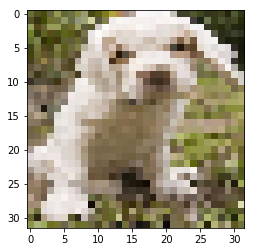

clumber


In [56]:
print(out.argmax(axis = 1))
print(target)

eg = inpt[0]
plt.imshow(eg.cpu().numpy().transpose(1,2,0))
plt.imsave("docs/pics/correctness check clumber.png",eg.cpu().numpy().transpose(1,2,0))
plt.show()

for k,i in traindataset.breed_dict.items():
#     print(k,i,out[0][0])
    if(i == out.argmax(axis = 1)[0]):
        print(k)


# The correctness check is passed
## 100%的正确率不是做错了！
[ 65  87  18  69  31 115  85 110   5  48  17  10  45  43  37  20  55  81
  20  43  78  12  95  20  29  26  41  55   1  84  71  82]
  
[ 65,  87,  18,  69,  31, 115,  85, 110,   5,  48,  17,  10,  45,  43,
         37,  20,  55,  81,  20,  43,  78,  12,  95,  20,  29,  26,  41,  55,
          1,  84,  71,  82], device='cuda:0')

Leonberg
![input](./docs/pics/correctness check leonberg.png)
./n02111129-Leonberg

looks like
n02111129_2750.jpg
![original](./docs/pics/n02111129_2750.jpg)

[ 40  64  76  59  86  15 111  43  72   9  49  36  91  40  97   8  20   2
  16  59  85   2  46  28  22 113  12  89  97   4 114 109]
[ 40,  64,  76,  59,  86,  15, 111,  43,  72,   9,  49,  36,  91,  40,
         97,   8,  20,   2,  16,  59,  85,   2,  46,  28,  22, 113,  12,  89,
         97,   4, 114, 109], device='cuda:0')

clumber
/n02101556-clumber
should be from this figure
![input](./docs/pics/correctness check clumber.png)
![original](./docs/pics/n02101556_2517.jpg)